In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import scipy.io

data = '/content/drive/MyDrive/Colab Notebooks/trajectory_data.csv'

Mounted at /content/drive


In [4]:
from typing import List, NamedTuple
import pandas as pd

class SensorData(NamedTuple):
    # Timestamp of the measurement
    time: float
    # Geographical latitude from GNSS (in degrees)
    true_lat: float
    # Geographical longitude from GNSS (in degrees)
    true_lon: float
    # Altitude from GNSS (in meters)
    true_alt: float
    # Roll angle from inertial sensors (in degrees)
    true_roll: float
    # Pitch angle from inertial sensors (in degrees)
    true_pitch: float
    # Heading angle from inertial sensors (in degrees)
    true_heading: float
    # Angular velocity around the x-axis from gyroscopes (in rad/s)
    gyro_x: float
    # Angular velocity around the y-axis from gyroscopes (in rad/s)
    gyro_y: float
    # Angular velocity around the z-axis from gyroscopes (in rad/s)
    gyro_z: float
    # Acceleration along the x-axis from accelerometers (in m/s²)
    accel_x: float
    # Acceleration along the y-axis from accelerometers (in m/s²)
    accel_y: float
    # Acceleration along the z-axis from accelerometers (in m/s²)
    accel_z: float
    # Measured latitude for filtering (in degrees)
    z_lat: float
    # Measured longitude for filtering (in degrees)
    z_lon: float
    # Measured altitude for filtering (in meters)
    z_alt: float
    # Measured northward velocity (in m/s)
    z_VN: float
    # Measured eastward velocity (in m/s)
    z_VE: float
    # Measured downward velocity (in m/s)
    z_VD: float


def parseData(filename: str) -> List[SensorData]:
    df = pd.read_csv(filename, header=0)
    data = [
        SensorData(
            time=row['time'],
            true_lat=row['true_lat'],
            true_lon=row['true_lon'],
            true_alt=row['true_alt'],
            true_roll=row['true_roll'],
            true_pitch=row['true_pitch'],
            true_heading=row['true_heading'],
            gyro_x=row['gyro_x'],
            gyro_y=row['gyro_y'],
            gyro_z=row['gyro_z'],
            accel_x=row['accel_x'],
            accel_y=row['accel_y'],
            accel_z=row['accel_z'],
            z_lat=row['z_lat'],
            z_lon=row['z_lon'],
            z_alt=row['z_alt'],
            z_VN=row['z_VN'],
            z_VE=row['z_VE'],
            z_VD=row['z_VD'],
        )
        for index, row in df.iterrows()
    ]

    return data

data_list = parseData('/content/drive/MyDrive/Colab Notebooks/trajectory_data.csv')
data_df = pd.DataFrame(data_list)  # Converts list of Data namedtuples to DataFrame
print(data_df.head())


   time   true_lat   true_lon  true_alt  true_roll  true_pitch  true_heading  \
0   0.0  41.431788 -71.305536    1000.0        0.0         0.0    195.000000   
1   1.0  41.431409 -71.305676    1000.0        0.0         0.0    195.237219   
2   2.0  41.431029 -71.305816    1000.0        0.0         0.0    195.316350   
3   3.0  41.430650 -71.305956    1000.0        0.0         0.0    195.355958   
4   4.0  41.430271 -71.306096    1000.0        0.0         0.0    195.379758   

     gyro_x    gyro_y    gyro_z   accel_x   accel_y   accel_z      z_lat  \
0 -0.000022  0.000054  0.004134  0.000255 -0.003881 -9.800712  41.431788   
1 -0.000036  0.000032  0.002904  0.000215 -0.003866 -9.800713  41.431409   
2 -0.000040  0.000046  0.000670  0.000234 -0.003856 -9.800696  41.431029   
3 -0.000017  0.000048  0.000554  0.000218 -0.003852 -9.800706  41.430650   
4 -0.000033  0.000044  0.000290  0.000230 -0.003878 -9.800691  41.430271   

       z_lon   z_alt       z_VN       z_VE          z_VD  
0 -

In [13]:
from __future__ import annotations
from haversine import Unit, haversine
from typing import List, Tuple
from scipy.linalg import sqrtm
from scipy.spatial.transform import Rotation
import numpy as np

        #Initializes the Unscented Kalman Filter with specified parameters.
        #:param k1: Tuning parameter that affects the spread of sigma points.
        #:param a1: Scale parameter influencing the sigma point spread around the mean.
        #:param b1: Parameter to incorporate prior knowledge of the distribution (for Gaussian, b1=2 is optimal).
        #:param modelType: Type of model ('FB' for feedback control, 'FF' for feedforward control).
        #:param noiseScaleMeasurement: Variance of measurement noise.
       # :param noiseScalePrediction: Variance of process noise.

class unscentedKalmanFilter:
    def __init__(self, k1: float = 1.0, a1: float = 1.0, b1: float = 0.4, modelType: str = "FEEDBACKMODEL", noiseScaleMeasurement: float = 5e-3, noiseScalePrediction: float = 1e-3,) -> unscentedKalmanFilter:
        self.modelType = modelType
        stateDimensions = 12 if self.modelType == "FEEDFORWARDMODEL" else 15
        self.stDim = stateDimensions
        self.noiseScaleMeasurement = noiseScaleMeasurement
        self.noiseScalePrediction = noiseScalePrediction

        self.numberOfSigmaPoints = 2 * self.stDim + 1
        self.k1 = k1
        self.a1 = a1
        self.b1 = b1
        self.lambdaScaling = self.a1**2 * (self.stDim + self.k1) - self.stDim
        # Calculate weights for the mean and covariance based on lambda scaling
        weightsMean0 = self.lambdaScaling / (self.stDim + self.lambdaScaling)
        weightsCovariance0 = ((self.lambdaScaling / (self.stDim + self.lambdaScaling)) + (1 - (self.a1**2)) + self.b1)

        weightI  = 1 / (2 * (self.stDim + self.lambdaScaling))
        # Initialize weight arrays for mean and covariance
        self.weightsMean  = np.zeros((self.numberOfSigmaPoints))
        self.weightsCovariance0 = np.zeros((self.numberOfSigmaPoints))
        self.weightsMean [0] = weightsMean0
        self.weightsMean [1:] = weightI
        self.weightsCovariance0[0] = weightsCovariance0
        self.weightsCovariance0[1:] = weightI

    def computeSigmaPoints(self, stateMean: np.ndarray, stateCovariance: np.ndarray) -> np.ndarray:
        #Generates sigma points for use in the Unscented Kalman Filter update.
        if not np.allclose(stateCovariance, stateCovariance.T):
            raise ValueError("Covariance matrix is not symmetric.")
        if np.any(np.linalg.eigvalsh(stateCovariance) <= 0):
            raise ValueError("Covariance matrix is not positive semi-definite.")

        sigmaPointsArray = np.zeros((self.numberOfSigmaPoints, self.stDim, 1))
        sigmaPointsArray[0] = stateMean  #First sigma point is the mean itself

        scaleFactor = (self.stDim + self.k1) # Scaling factor for adjusting sigma points spread
        try:
            sqrtCovMatrix = sqrtm(scaleFactor * stateCovariance)
        except Exception as e:
            raise ValueError("Failed to compute the square root of the covariance matrix.") from e
        # Generate sigma points by adding and subtracting scaled square root of covariance matrix
        for i in range(self.stDim):
            adjustmentVector = sqrtCovMatrix[:, i].reshape((self.stDim, 1))
            sigmaPointsArray[i + 1] = stateMean + adjustmentVector
            sigmaPointsArray[self.stDim + i + 1] = stateMean - adjustmentVector

        return sigmaPointsArray

    def propagationModel(self, state: np.ndarray, deltaTime: float, bodyFrameAcceleration: np.ndarray, bodyFrameAngularRate: np.ndarray) -> np.ndarray:
        # Reshape body frame acceleration and angular rate for matrix operations
        bodyFrameAcceleration = np.array(bodyFrameAcceleration).reshape(3, 1)
        bodyFrameAngularRate = np.array(bodyFrameAngularRate).reshape(3, 1)

        # Extract state variables for easier handling
        latitude, longitude, altitude, roll, pitch, yaw, velocityNorth, velocityEast, velocityDown = state[:9, 0]
        velocityVector = np.array([velocityNorth, velocityEast, velocityDown]).reshape(3, 1)

        # Compensate for feedback model corrections if applicable
        if self.modelType == "FEEDBACKMODEL":
            bodyFrameAcceleration -= state[9:12]
            bodyFrameAngularRate -= state[12:15]

        # Convert roll, pitch, yaw into a rotation matrix
        previousRotationMatrix = Rotation.from_euler("xyz", [roll, pitch, yaw], degrees=True).as_matrix()

        # Define Earth's rotation rate and create the corresponding skew-symmetric matrix
        earthRate = earthRotationRate
        earthRateMatrix = np.array([[0, -earthRate, 0], [earthRate, 0, 0], [0, 0, 0]])

        # Calculate principal radii based on current latitude and altitude
        radiusNorth, radiusEast, radiusEastCosLatitude = calculatePrincipalRadii(latitude, altitude)

        # Compute angular rates of change in navigation frame and create the corresponding skew-symmetric matrix
        omegaNe = np.array([velocityEast / radiusEast, -velocityNorth / radiusNorth, -(velocityEast * np.tan(np.deg2rad(latitude))) / radiusEast]).reshape(3, 1)
        skewOmegaNe = np.array([
            [0, -omegaNe[2, 0], omegaNe[1, 0]],
            [omegaNe[2, 0], 0, -omegaNe[0, 0]],
            [-omegaNe[1, 0], omegaNe[0, 0], 0],
        ])

        # Create a skew-symmetric matrix for body frame angular rates
        skewOmegaBi = np.array([
            [0, -bodyFrameAngularRate[2, 0], bodyFrameAngularRate[1, 0]],
            [bodyFrameAngularRate[2, 0], 0, -bodyFrameAngularRate[0, 0]],
            [-bodyFrameAngularRate[1, 0], bodyFrameAngularRate[0, 0], 0]
        ])

        # Update the rotation matrix with current angular movements
        updatedRotationMatrix = previousRotationMatrix @ (np.eye(3) + skewOmegaBi * deltaTime) - ((earthRateMatrix + skewOmegaNe) @ previousRotationMatrix * deltaTime)

        # Correct acceleration with updated rotation matrices
        correctedAcceleration = 0.5 * (previousRotationMatrix + updatedRotationMatrix) @ bodyFrameAcceleration
        updatedVelocity = velocityVector + deltaTime * (correctedAcceleration + calculateGravity(latitude, altitude) - (skewOmegaNe + 2 * earthRateMatrix) @ velocityVector)

        # Calculate new altitude based on updated velocity
        newAltitude = altitude - deltaTime * 0.5 * (velocityDown + updatedVelocity[2, 0])
        radiusNorthNew, _, _ = calculatePrincipalRadii(latitude, newAltitude)
        newLatitude = latitude + deltaTime * 0.5 * (velocityNorth / radiusNorth + updatedVelocity[0, 0] / radiusNorth)
        newLatitude += deltaTime * 0.5 * (velocityNorth / radiusNorthNew + updatedVelocity[0, 0] / radiusNorthNew)

        # Adjust longitude with updated eastward velocity
        _, _, radiusEastCosLatitudeNew = calculatePrincipalRadii(newLatitude, newAltitude)
        newLongitude = longitude + deltaTime * 0.5 * (velocityEast / radiusEastCosLatitude + velocityEast / radiusEastCosLatitudeNew)

        # Derive new roll, pitch, and yaw from the updated rotation matrix
        newRoll, newPitch, newYaw = Rotation.from_matrix(updatedRotationMatrix).as_euler('xyz', degrees=True)

        # Compile new state including unchanged state elements
        newState = np.zeros((self.stDim, 1))
        newState[:9, 0] = [newLatitude, newLongitude, newAltitude, newRoll, newPitch, newYaw, updatedVelocity[0, 0], updatedVelocity[1, 0], updatedVelocity[2, 0]]
        newState[9:, 0] = state[9:, 0]

        return newState

    def updateState(self, measuredValues, stateMean, stateCovariance, sigmaPoints):
        # Define the size of the measurements and state
        measurementSize = measuredValues.shape[0]
        stateSize = self.stDim

        # Initialize the measurement matrix for mapping sigma points to measurements
        measurementMatrix = np.zeros((measurementSize, stateSize))
        measurementMatrix[0, 0] = 1
        measurementMatrix[1, 1] = 1
        measurementMatrix[2, 2] = 1
        measurementMatrix[3, 6] = 1
        measurementMatrix[4, 7] = 1
        measurementMatrix[5, 8] = 1

        # Transform sigma points into measurement space
        transformedSigmaPoints = np.dot(measurementMatrix, sigmaPoints.T).T

        # Calculate predicted measurements from transformed sigma points
        predictedMeasurements = np.zeros((measurementSize, 1))
        for i in range(self.numberOfSigmaPoints):
            predictedMeasurements += self.weightsMean[i] * transformedSigmaPoints[i].reshape(measurementSize, 1)

        # Compute the innovation covariance matrix for the measurements
        innovationCovariance = np.zeros((measurementSize, measurementSize))
        for i in range(self.numberOfSigmaPoints):
            measurementDiff = transformedSigmaPoints[i].reshape(measurementSize, 1) - predictedMeasurements
            innovationCovariance += self.weightsCovariance0[i] * np.outer(measurementDiff, measurementDiff)
        measurementNoise = np.diag([0.1, 0.1, 1, 0.1, 0.1, 0.1])
        innovationCovariance += measurementNoise

        # Calculate cross-covariance between state and measurements
        crossCovariance = np.zeros((stateSize, measurementSize))
        for i in range(self.numberOfSigmaPoints):
            stateDiff = sigmaPoints[i].reshape(stateSize, 1) - stateMean
            measurementDiff = transformedSigmaPoints[i].reshape(measurementSize, 1) - predictedMeasurements
            crossCovariance += self.weightsCovariance0[i] * np.dot(stateDiff, measurementDiff.T)

        # Calculate the Kalman gain
        kalmanGain = np.dot(crossCovariance, np.linalg.inv(innovationCovariance))

        # Update state mean and covariance using the Kalman gain and measurement residual
        measurementResidual = measuredValues - predictedMeasurements
        updatedStateMean = stateMean + np.dot(kalmanGain, measurementResidual)
        updatedStateCovariance = stateCovariance - np.dot(np.dot(kalmanGain, innovationCovariance), kalmanGain.T)

        return updatedStateMean, updatedStateCovariance

    def fixCovariance(self, matrixCovariance: np.ndarray, jitterAmount: float = 1e-3):
        # Check if the matrix is symmetric and positive definite
        isSymmetric = np.allclose(matrixCovariance, matrixCovariance.T)
        isPositiveDefinite = True
        try:
            np.linalg.cholesky(matrixCovariance)
        except np.linalg.LinAlgError:
            isPositiveDefinite = False

        # If already symmetric and positive definite, return as is
        if isSymmetric and isPositiveDefinite:
            return matrixCovariance

        # Adjust the matrix to be symmetric
        matrixCovariance = (matrixCovariance + matrixCovariance.T) / 2

        # Adjust eigenvalues to ensure the matrix is positive definite
        eigenValues, eigenVectors = np.linalg.eig(matrixCovariance)
        eigenValues[eigenValues < 0] = 0
        eigenValues += jitterAmount

        # Reconstruct the matrix using adjusted eigenvalues
        matrixCovariance = eigenVectors.dot(np.diag(eigenValues)).dot(eigenVectors.T)

        return self.fixCovariance(matrixCovariance, jitterAmount=10 * jitterAmount)


    def getPrediction(self, sigmaPoints: np.ndarray, bodyFrameAcceleration: np.ndarray, bodyFrameAngularRate: np.ndarray, deltaTime: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        # Initialize array to hold transformed sigma points
        transitionedPoints = np.zeros_like(sigmaPoints)
        # Transform each sigma point through the motion model
        for i in range(sigmaPoints.shape[0]):
            transitionedPoints[i, :] = self.propagationModel(sigmaPoints[i], deltaTime, bodyFrameAngularRate, bodyFrameAcceleration)

        # Calculate the predicted mean of the state
        predictedMean = np.zeros((self.stDim, 1))
        for i in range(self.numberOfSigmaPoints):
            predictedMean += self.weightsMean[i] * transitionedPoints[i]

        # Determine noise scale based on the model type
        if self.modelType == "FEEDFORWARDMODEL":
            noiseScale = 1e-3
        else:
            noiseScale = 5e-5

        # Compute the process noise covariance matrix
        processNoiseCovariance = np.random.normal(scale=self.noiseScalePrediction, size=(self.stDim, self.stDim))
        # Calculate state differences for the covariance update
        stateDifferences = transitionedPoints - predictedMean
        predictedCovariance = np.zeros((self.stDim, self.stDim))
        # Compute the predicted covariance matrix by summing weighted outer products of state differences
        for i in range(self.numberOfSigmaPoints):
            predictedCovariance += self.weightsCovariance0[i] * np.dot(stateDifferences[i], stateDifferences[i].T)
        predictedCovariance += processNoiseCovariance

        return predictedMean, predictedCovariance, transitionedPoints

    def processMeasurements(self, data: List[SensorData]) -> Tuple[List[np.ndarray], List[np.ndarray], List[float]]:
        groundTruth = [self.truePoseFromData(d) for d in data]
        filteredPositions = [self.truePoseFromData(data[0])]  # Initialize with the first state
        haversineDistances = []

        # Initialize state and time from the first data entry
        currentState = filteredPositions[0]
        previousStateTimestamp = data[0].time

        # Set initial process covariance matrix
        processCovarianceMatrix = np.eye(self.stDim) * 1e-3

        # Iterate over sensor data starting from the second entry
        for index in range(1, len(data)):
            read = data[index]
            deltaTime = read.time - previousStateTimestamp
            previousStateTimestamp = read.time

            # Extract IMU and GNSS data from the sensor readings
            imuData = self.imuFromData(read)
            gnssData = self.gnssFromData(read)
            bodyFrameAcceleration = imuData[0:3]
            bodyFrameAngularRate = imuData[3:6]

            # Generate sigma points, predict next state, and update
            sigmaPoints = self.computeSigmaPoints(currentState, processCovarianceMatrix)
            predictedMu, predictedSigma, transitionedPoints = self.getPrediction(sigmaPoints, bodyFrameAcceleration, bodyFrameAngularRate, deltaTime)
            updatedMu, updatedSigma = self.update(gnssData, predictedMu, predictedSigma, transitionedPoints)

            # Update the state and covariance matrices
            processCovarianceMatrix = updatedSigma
            currentState = updatedMu

            # Store the updated state and calculate distance to ground truth
            filteredPositions.append(currentState)
            haversineDistance = haversine(
                (currentState[0], currentState[1]),
                (groundTruth[index][0], groundTruth[index][1]),
                unit='degrees'
            )
            haversineDistances.append(haversineDistance)

        return filteredPositions, groundTruth, haversineDistances



In [7]:
import numpy as np

earthRotationRate = 7.292115e-5  # earth's rotation rate in radians per second
equatorialRadius = 6378137.0  # earth's equatorial radius in meters
eccentricitySquared = 6.6943799901413e-3  # square of earth's eccentricity
gravityEquatorial = 9.7803253359  # gravity at equator in m/s²
gravityPolar = 9.8321849378  # gravity at poles in m/s²
flatteningFactor = (1 - eccentricitySquared) ** 0.5 * gravityPolar / gravityEquatorial - 1  # flattening factor for gravity adjustment

def calculatePrincipalRadii(latitude, altitude):
    sinLatitude = np.sin(np.deg2rad(latitude))  # sin of latitude in radians
    cosLatitude = np.sqrt(1 - sinLatitude**2)  # cos of latitude derived from sin latitude

    curvature = 1 - eccentricitySquared * sinLatitude**2  # curvature at given latitude
    radiusEquatorial = equatorialRadius / np.sqrt(curvature)  # radius of curvature in equatorial plane
    radiusNormal = radiusEquatorial * (1 - eccentricitySquared) / curvature  # normal radius of curvature
    return radiusNormal + altitude, radiusEquatorial + altitude, (radiusEquatorial + altitude) * cosLatitude  # returns radii adjusted for altitude

def calculateGravity(latitude, altitude):
    sinLatitude = np.sin(np.deg2rad(latitude))  # sin of latitude in radians
    altitudeArray = np.asarray(altitude)  # convert altitude to numpy array for operations
    gravityValue = gravityEquatorial * (1 + flatteningFactor * sinLatitude**2) / (1 - eccentricitySquared * sinLatitude**2) ** 0.5  # calculated gravity based on latitude
    adjustedGravity = gravityValue * (1 - 2 * altitudeArray / equatorialRadius)  # adjust gravity for altitude
    return adjustedGravity  # return adjusted gravity value

def calculateGravityVector(latitude, altitude):
    gravityValue = calculateGravity(latitude, altitude)  # get gravity value from calculateGravity function
    if gravityValue.ndim == 0:
        return np.array([0, 0, gravityValue])  # if scalar, return as vector pointing in z-direction
    else:
        gravityVector = np.zeros((len(gravityValue), 3))  # prepare zero vector for multiple values
        gravityVector[:, 2] = gravityValue  # set z-axis values
        return gravityVector  # return 3D gravity vector


In [8]:
import numpy as np

def get_sensor_measurements(data_df, index, add_noise=True):
    """
    Retrieves and optionally simulates sensor measurements for a given index from the data DataFrame.

    Parameters:
        data_df (DataFrame): The DataFrame containing all sensor data.
        index (int): Index for which to retrieve data.
        add_noise (bool): Whether to add simulated noise to the measurements.

    Returns:
        dict: A dictionary containing simulated sensor measurements.
    """
    # Standard deviations for simulated noise (example values)
    pos_std = 0.5  # meters for position
    vel_std = 0.1  # m/s for velocity
    att_std = np.deg2rad(0.5)  # radians for attitude
    acc_std = 0.01  # m/s^2 for acceleration
    gyro_std = np.deg2rad(0.01)  # rad/s for gyro

    measurement = {
        "gnss": {
            "lat": data_df.at[index, 'z_lat'] + (np.random.randn() * pos_std if add_noise else 0),
            "lon": data_df.at[index, 'z_lon'] + (np.random.randn() * pos_std if add_noise else 0),
            "alt": data_df.at[index, 'z_alt'] + (np.random.randn() * pos_std if add_noise else 0),
            "vn": data_df.at[index, 'z_VN'] + (np.random.randn() * vel_std if add_noise else 0),
            "ve": data_df.at[index, 'z_VE'] + (np.random.randn() * vel_std if add_noise else 0),
            "vd": data_df.at[index, 'z_VD'] + (np.random.randn() * vel_std if add_noise else 0)
        },
        "imu": {
            "gyro_x": data_df.at[index, 'gyro_x'] + (np.random.randn() * gyro_std if add_noise else 0),
            "gyro_y": data_df.at[index, 'gyro_y'] + (np.random.randn() * gyro_std if add_noise else 0),
            "gyro_z": data_df.at[index, 'gyro_z'] + (np.random.randn() * gyro_std if add_noise else 0),
            "accel_x": data_df.at[index, 'accel_x'] + (np.random.randn() * acc_std if add_noise else 0),
            "accel_y": data_df.at[index, 'accel_y'] + (np.random.randn() * acc_std if add_noise else 0),
            "accel_z": data_df.at[index, 'accel_z'] + (np.random.randn() * acc_std if add_noise else 0)
        }
    }
    return measurement

def generate_noise_samples(num_samples, std_dev):
    """
    Generates multiple samples of noise for simulation purposes.

    Parameters:
        num_samples (int): Number of noise samples to generate.
        std_dev (float): Standard deviation of the noise.

    Returns:
        np.ndarray: Array of noise samples.
    """
    return np.random.normal(0, std_dev, num_samples)

# Example of generating multiple noise samples for position noise
num_samples = 1000
pos_noise_samples = generate_noise_samples(num_samples, 0.5)  # 0.5 meters std dev

# Assume data_df has been properly loaded and prepared
for index in range(5):  # Just an example to print first 5 entries
    current_measurement = get_sensor_measurements(data_df, index, add_noise=True)
    print(f"Measurements for index {index}: {current_measurement}")

def propagate_state(current_state, dt, imu_measurements, lat, alt):
    position = np.array(current_state['position'])
    velocity = np.array(current_state['velocity'])
    orientation = np.array(current_state['orientation'])

    acceleration = np.array(imu_measurements['acceleration'])
    gyro = np.array(imu_measurements['gyro'])

    # Assuming gravity needs to be negative in the z-direction
    gravity_vector = calculateGravityVector(lat, alt)
    gravity_vector[2] = -abs(gravity_vector[2])  # Ensure gravity is directed downward

    new_velocity = velocity + (acceleration + gravity_vector) * dt
    new_position = position + velocity * dt + 0.5 * (acceleration + gravity_vector) * dt**2
    new_orientation = orientation + gyro * dt
    print("Gravity Vector:", gravity_vector)
    print("Acceleration Input:", acceleration)
    print("Updated Velocity:", new_velocity)
    print("Updated Position:", new_position)

    return {'position': new_position, 'velocity': new_velocity, 'orientation': new_orientation}


# Example initial state
current_state = {
    'position': np.array([0, 0, 0]),
    'velocity': np.array([0, 0, 0]),
    'orientation': np.array([0, 0, 0])  # Assuming roll, pitch, yaw in radians
}

# Example IMU measurements
imu_measurements = {
    'acceleration': np.array([0, 0, -9.81]),  # Simple static example
    'gyro': np.array([0, 0, 0])
}

# Propagate state
updated_state = propagate_state(current_state, 1.0, imu_measurements, 45.0, 100)  # dt = 1 second, lat 45 deg, alt 100 m

Measurements for index 0: {'gnss': {'lat': 41.65862518976453, 'lon': -71.49819925062137, 'alt': 1000.1729023754139, 'vn': -42.145703971975095, 've': -11.755974052460914, 'vd': 0.16376201967459167}, 'imu': {'gyro_x': 3.022178345849247e-05, 'gyro_y': 0.00015609105052729897, 'gyro_z': 0.004411463651511976, 'accel_x': -0.0015838495982475828, 'accel_y': 0.002735820256406711, 'accel_z': -9.801069496855805}}
Measurements for index 1: {'gnss': {'lat': 41.51170498397031, 'lon': -71.44292493002051, 'alt': 1000.019549771573, 'vn': -41.8783557928896, 've': -11.790987506426116, 'vd': 0.11551541371459387}, 'imu': {'gyro_x': -0.00014242076396143354, 'gyro_y': -0.00018215583847527945, 'gyro_z': 0.0032436949461030653, 'accel_x': 0.006017737150631841, 'accel_y': 0.003676626093680612, 'accel_z': -9.79750656255061}}
Measurements for index 2: {'gnss': {'lat': 41.75972424536724, 'lon': -70.80610564046155, 'alt': 999.8483758124179, 'vn': -42.30431224617842, 've': -11.633356357981421, 'vd': -0.124135710953901

In [35]:
import numpy as np
import pandas as pd  # Make sure to import pandas
import matplotlib.pyplot as plt


def predict_state(ukf, delta_t, fb, wb):
    sigma_points = ukf.computeSigmaPoints(ukf.mu, ukf.sigma)
    predicted_mu, predicted_sigma, _ = ukf.getPrediction(sigma_points, fb, wb, delta_t)
    predicted_sigma = ukf.fixCovariance(predicted_sigma)
    return predicted_mu, predicted_sigma

def update_state(ukf, predicted_mu, predicted_sigma, actual_measurements):
    sigma_points = ukf.computeSigmaPoints(predicted_mu, predicted_sigma)
    updated_mu, updated_sigma = ukf.updateState(actual_measurements, predicted_mu, predicted_sigma, sigma_points)
    updated_sigma = ukf.fixCovariance(updated_sigma)
    return updated_mu, updated_sigma

# Initialize UKF with specified noise parameters
ukf = unscentedKalmanFilter(
    modelType='FEEDBACKMODEL',  # Feedback model type
    noiseScaleMeasurement=0.50,
    noiseScalePrediction=1e-4,
    k1=0,
    a1=1e-3,
    b1=2
)

ukf.mu = np.zeros((ukf.stDim, 1))  # Initialize state estimate as zero
ukf.sigma = np.eye(ukf.stDim) * 0.1  # Initial covariance

# Load data
data_df = pd.DataFrame(data_list)  # Assume data_list is previously defined

# Lists to store trajectory data for plotting
lon_true, lat_true = [], []
lon_est, lat_est = [], []

# Processing a limited number of data points for demonstration
for index in range(min(20000, len(data_df))):  # Processing only first 500 points
    current_measurement = get_sensor_measurements(data_df, index, add_noise=True)

    fb = np.array([current_measurement['imu']['accel_x'], current_measurement['imu']['accel_y'], current_measurement['imu']['accel_z']])
    wb = np.array([current_measurement['imu']['gyro_x'], current_measurement['imu']['gyro_y'], current_measurement['imu']['gyro_z']])
    delta_t = 1.0  # Assuming 1 second time intervals for simplicity

    actual_measurements = np.array([
        current_measurement['gnss']['lat'],
        current_measurement['gnss']['lon'],
        current_measurement['gnss']['alt'],
        current_measurement['gnss']['vn'],
        current_measurement['gnss']['ve'],
        current_measurement['gnss']['vd']
    ]).reshape(6, 1)  # Reshape for consistency with UKF state dimensions

    predicted_mu, predicted_sigma = predict_state(ukf, delta_t, fb, wb)
    updated_mu, updated_sigma = update_state(ukf, predicted_mu, predicted_sigma, actual_measurements)

    # Storing estimated and true positions for trajectory plotting
    lon_est.append(updated_mu[1][0])
    lat_est.append(updated_mu[0][0])
    lon_true.append(current_measurement['gnss']['lon'])
    lat_true.append(current_measurement['gnss']['lat'])

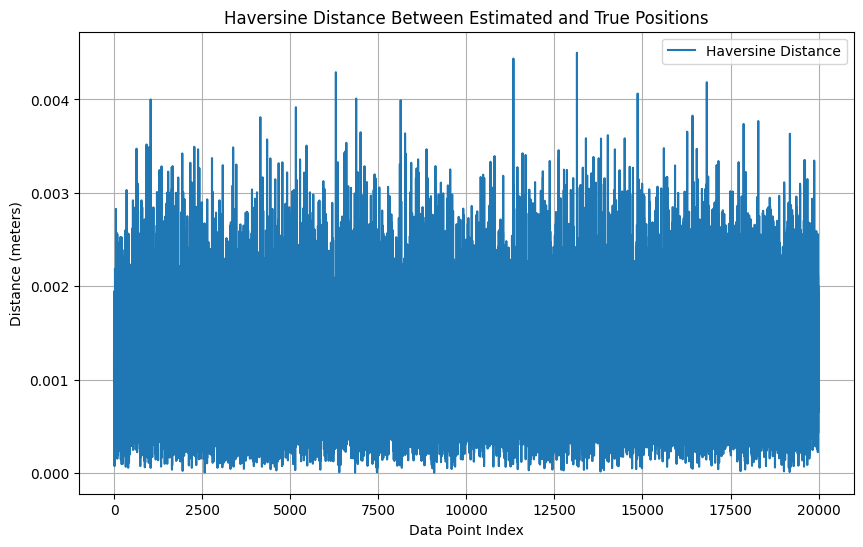

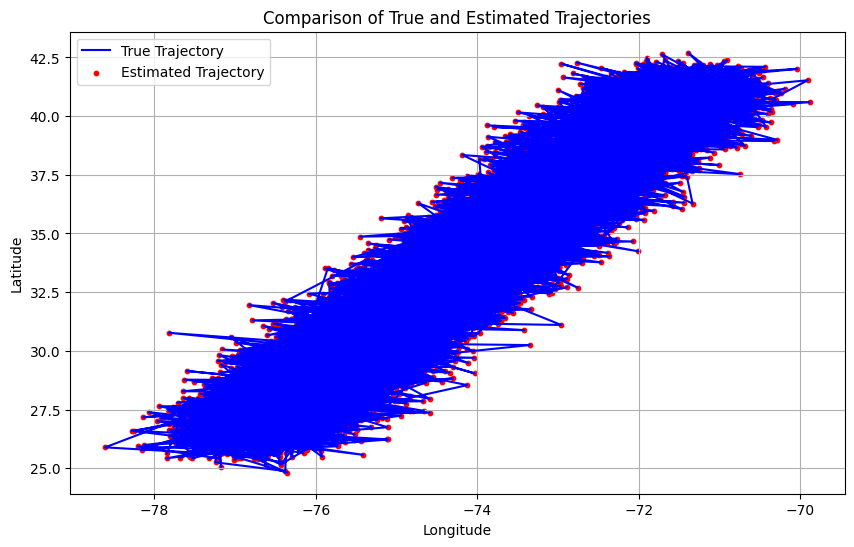

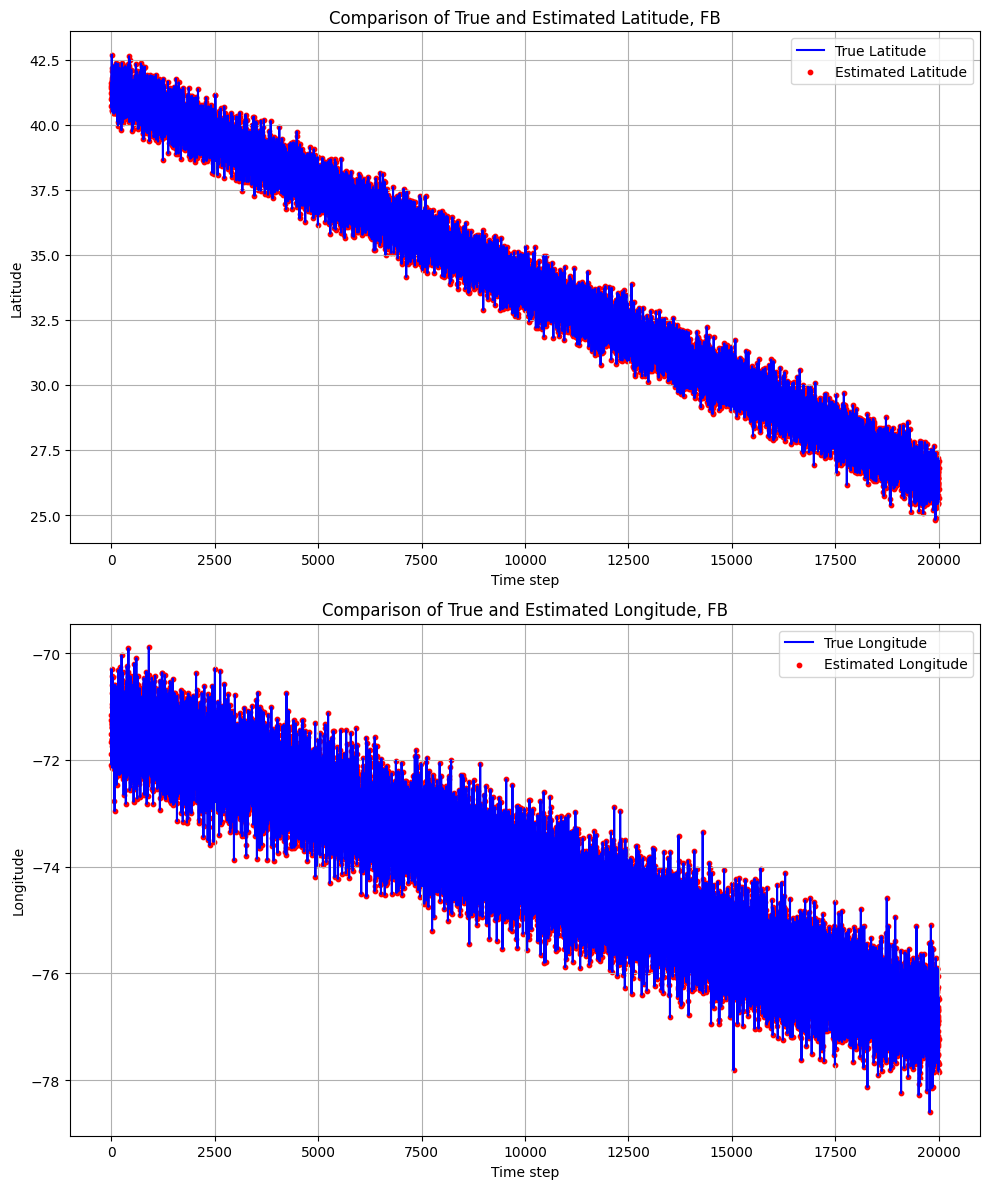

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def haversine(coord1, coord2):
    # Radius of the Earth in kilometers
    R = 6371.0
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c * 1000  # Convert to meters
    return distance

# Calculate Haversine distances
haversine_distances = [haversine((lat_true[i], lon_true[i]), (lat_est[i], lon_est[i])) for i in range(len(lat_true))]

# Plotting Haversine distances
plt.figure(figsize=(10, 6))
plt.plot(haversine_distances, label='Haversine Distance')
plt.xlabel('Data Point Index')
plt.ylabel('Distance (meters)')
plt.title('Haversine Distance Between Estimated and True Positions')
plt.legend()
plt.grid(True)
plt.show()

# Assuming lon_true, lat_true, lon_est, lat_est are your lists of longitudes and latitudes

plt.figure(figsize=(10, 6))
plt.plot(lon_true, lat_true, 'b-', label='True Trajectory')  # True trajectory as a line
plt.scatter(lon_est, lat_est, color='red', s=10, label='Estimated Trajectory')  # Estimated as dots
plt.title('Comparison of True and Estimated Trajectories')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt

# Assuming lon_true, lat_true, lon_est, lat_est are lists of longitudes and latitudes

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot for latitude comparison
axs[0].plot(range(len(lat_true)), lat_true, 'b-', label='True Latitude')
axs[0].scatter(range(len(lat_est)), lat_est, color='red', s=10, label='Estimated Latitude')
axs[0].set_title('Comparison of True and Estimated Latitude, FB')
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Latitude')
axs[0].legend()
axs[0].grid(True)

# Plot for longitude comparison
axs[1].plot(range(len(lon_true)), lon_true, 'b-', label='True Longitude')
axs[1].scatter(range(len(lon_est)), lon_est, color='red', s=10, label='Estimated Longitude')
axs[1].set_title('Comparison of True and Estimated Longitude, FB')
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Longitude')
axs[1].legend()
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
def simulate_trajectory(initial_state, dt, total_time, imu_measurements, lat, alt):
    states = [initial_state]
    current_state = initial_state
    for _ in range(int(total_time / dt)):
        current_state = propagate_state(current_state, dt, imu_measurements, lat, alt)
        states.append(current_state)
    return states

# Define the simulation parameters
dt = 1.0  # Time step in seconds
total_time = 10.0  # Total simulation time in seconds
lat = 45.0  # Latitude in degrees
alt = 100.0  # Altitude in meters

# Use the same initial state and IMU measurements as before
initial_state = {
    'position': np.array([0, 0, 0]),
    'velocity': np.array([0, 0, 0]),
    'orientation': np.array([0, 0, 0])  # Assuming roll, pitch, yaw in radians
}
imu_measurements = {
    'acceleration': np.array([0, 0, -9.81]),  # Simple static example with gravity only
    'gyro': np.array([0, 0, 0])
}

# Simulate the trajectory
trajectory = simulate_trajectory(initial_state, dt, total_time, imu_measurements, lat, alt)


Gravity Vector: [ 0.          0.         -9.80589028]
Acceleration Input: [ 0.    0.   -9.81]
Updated Velocity: [  0.           0.         -19.61589028]
Updated Position: [ 0.          0.         -9.80794514]
Gravity Vector: [ 0.          0.         -9.80589028]
Acceleration Input: [ 0.    0.   -9.81]
Updated Velocity: [  0.           0.         -39.23178055]
Updated Position: [  0.           0.         -39.23178055]
Gravity Vector: [ 0.          0.         -9.80589028]
Acceleration Input: [ 0.    0.   -9.81]
Updated Velocity: [  0.           0.         -58.84767083]
Updated Position: [  0.           0.         -88.27150624]
Gravity Vector: [ 0.          0.         -9.80589028]
Acceleration Input: [ 0.    0.   -9.81]
Updated Velocity: [  0.          0.        -78.4635611]
Updated Position: [   0.           0.        -156.9271222]
Gravity Vector: [ 0.          0.         -9.80589028]
Acceleration Input: [ 0.    0.   -9.81]
Updated Velocity: [  0.           0.         -98.07945138]
Updat

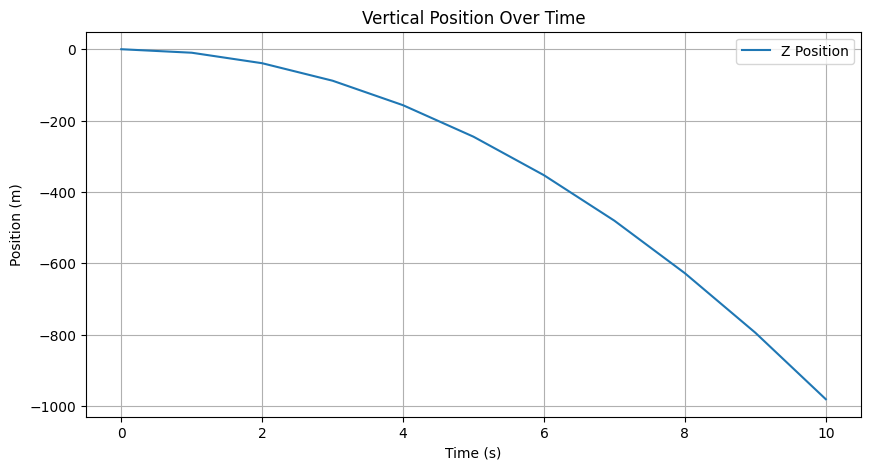

In [ ]:
import matplotlib.pyplot as plt

positions = [state['position'] for state in trajectory]  # trajectory is a list of states
times = list(range(len(positions)))

plt.figure(figsize=(10, 5))
plt.plot(times, [pos[2] for pos in positions], label='Z Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Vertical Position Over Time')
plt.legend()
plt.grid(True)
plt.show()


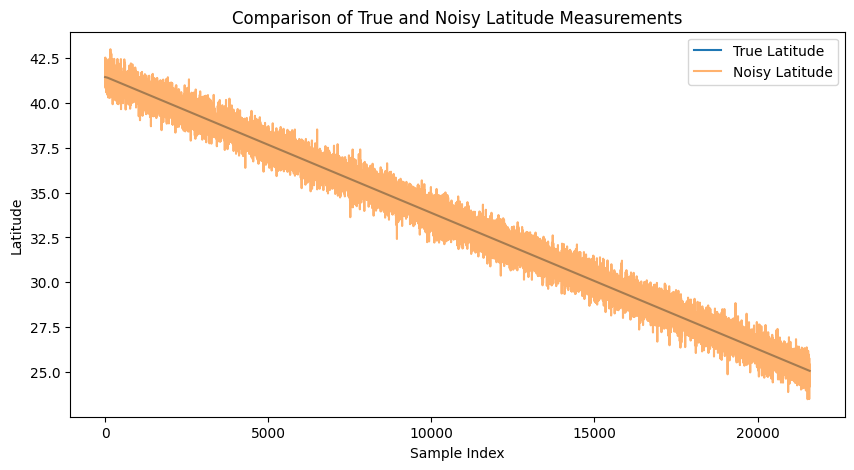

In [ ]:
import matplotlib.pyplot as plt

# Extract true and noisy latitude measurements
true_lat = data_df['true_lat']
noisy_lat = data_df['z_lat'] + np.random.normal(0, 0.5, len(data_df))

plt.figure(figsize=(10, 5))
plt.plot(true_lat, label='True Latitude')
plt.plot(noisy_lat, label='Noisy Latitude', a1=0.6)
plt.title('Comparison of True and Noisy Latitude Measurements')
plt.xlabel('Sample Index')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [38]:
import numpy as np
import pandas as pd  # Make sure to import pandas
import matplotlib.pyplot as plt


def predict_state(ukf, delta_t, fb, wb):
    sigma_points = ukf.computeSigmaPoints(ukf.mu, ukf.sigma)
    predicted_mu, predicted_sigma, _ = ukf.getPrediction(sigma_points, fb, wb, delta_t)
    predicted_sigma = ukf.fixCovariance(predicted_sigma)
    return predicted_mu, predicted_sigma

def update_state(ukf, predicted_mu, predicted_sigma, actual_measurements):
    sigma_points = ukf.computeSigmaPoints(predicted_mu, predicted_sigma)
    updated_mu, updated_sigma = ukf.updateState(actual_measurements, predicted_mu, predicted_sigma, sigma_points)
    updated_sigma = ukf.fixCovariance(updated_sigma)
    return updated_mu, updated_sigma

# Initialize UKF with specified noise parameters
ukf = unscentedKalmanFilter(
    modelType='FEEDFORWARDMODEL',  # Feedback model type
    noiseScaleMeasurement=0.50,
    noiseScalePrediction=1e-4,
    k1=0,
    a1=1e-3,
    b1=2
)

ukf.mu = np.zeros((ukf.stDim, 1))  # Initialize state estimate as zero
ukf.sigma = np.eye(ukf.stDim) * 0.1  # Initial covariance

# Load data
data_df = pd.DataFrame(data_list)  # Assume data_list is previously defined

# Lists to store trajectory data for plotting
lon_true, lat_true = [], []
lon_est, lat_est = [], []

# Processing a limited number of data points for demonstration
for index in range(min(20000, len(data_df))):  # Processing only first 500 points
    current_measurement = get_sensor_measurements(data_df, index, add_noise=True)

    fb = np.array([current_measurement['imu']['accel_x'], current_measurement['imu']['accel_y'], current_measurement['imu']['accel_z']])
    wb = np.array([current_measurement['imu']['gyro_x'], current_measurement['imu']['gyro_y'], current_measurement['imu']['gyro_z']])
    delta_t = 1.0  # Assuming 1 second time intervals for simplicity

    actual_measurements = np.array([
        current_measurement['gnss']['lat'],
        current_measurement['gnss']['lon'],
        current_measurement['gnss']['alt'],
        current_measurement['gnss']['vn'],
        current_measurement['gnss']['ve'],
        current_measurement['gnss']['vd']
    ]).reshape(6, 1)  # Reshape for consistency with UKF state dimensions

    predicted_mu, predicted_sigma = predict_state(ukf, delta_t, fb, wb)
    updated_mu, updated_sigma = update_state(ukf, predicted_mu, predicted_sigma, actual_measurements)

    # Storing estimated and true positions for trajectory plotting
    lon_est.append(updated_mu[1][0])
    lat_est.append(updated_mu[0][0])
    lon_true.append(current_measurement['gnss']['lon'])
    lat_true.append(current_measurement['gnss']['lat'])

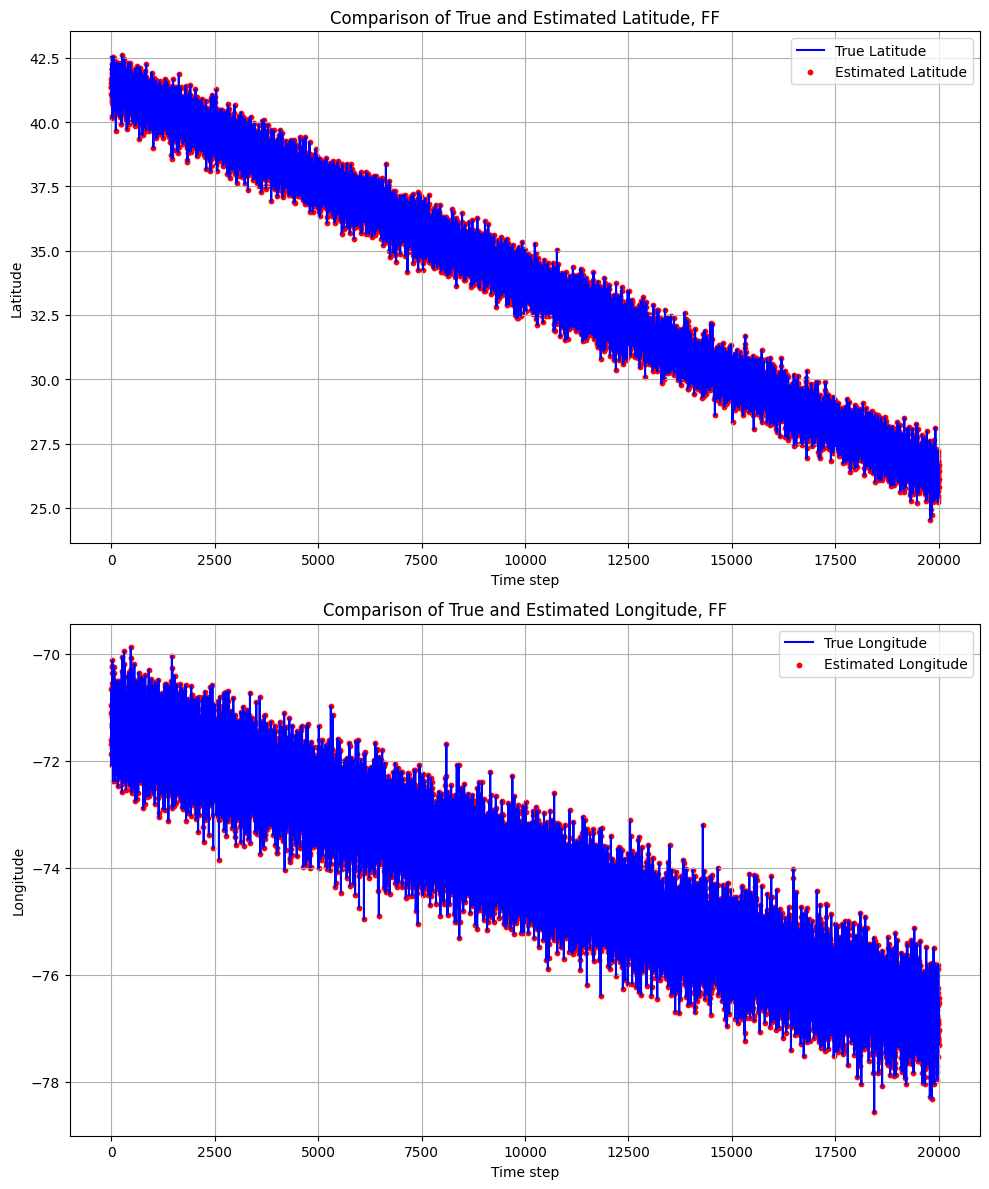

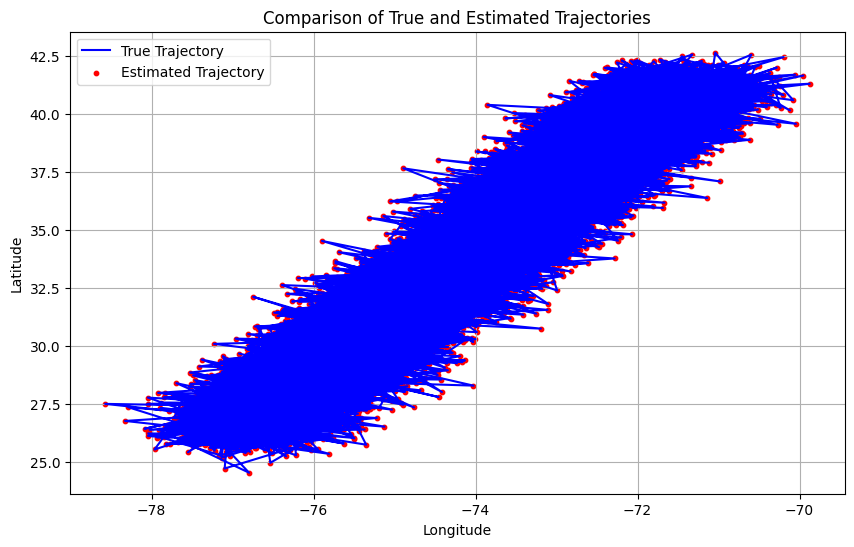

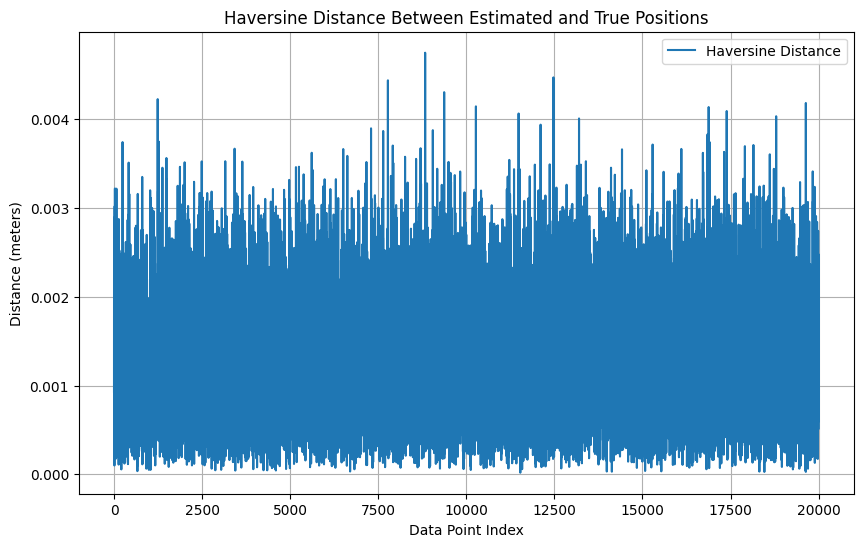

In [39]:
import matplotlib.pyplot as plt

# Assuming lon_true, lat_true, lon_est, lat_est are lists of longitudes and latitudes

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot for latitude comparison
axs[0].plot(range(len(lat_true)), lat_true, 'b-', label='True Latitude')
axs[0].scatter(range(len(lat_est)), lat_est, color='red', s=10, label='Estimated Latitude')
axs[0].set_title('Comparison of True and Estimated Latitude, FF')
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Latitude')
axs[0].legend()
axs[0].grid(True)

# Plot for longitude comparison
axs[1].plot(range(len(lon_true)), lon_true, 'b-', label='True Longitude')
axs[1].scatter(range(len(lon_est)), lon_est, color='red', s=10, label='Estimated Longitude')
axs[1].set_title('Comparison of True and Estimated Longitude, FF')
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Longitude')
axs[1].legend()
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Assuming lon_true, lat_true, lon_est, lat_est are your lists of longitudes and latitudes

plt.figure(figsize=(10, 6))
plt.plot(lon_true, lat_true, 'b-', label='True Trajectory')  # True trajectory as a line
plt.scatter(lon_est, lat_est, color='red', s=10, label='Estimated Trajectory')  # Estimated as dots
plt.title('Comparison of True and Estimated Trajectories')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

def haversine(coord1, coord2):
    # Radius of the Earth in kilometers
    R = 6371.0
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c * 1000  # Convert to meters
    return distance

# Assuming lon_true, lat_true, lon_est, lat_est are already populated lists from data processing

# Calculate Haversine distances
haversine_distances = [haversine((lat_true[i], lon_true[i]), (lat_est[i], lon_est[i])) for i in range(len(lat_true))]

# Plotting Haversine distances
plt.figure(figsize=(10, 6))
plt.plot(haversine_distances, label='Haversine Distance')
plt.xlabel('Data Point Index')
plt.ylabel('Distance (meters)')
plt.title('Haversine Distance Between Estimated and True Positions')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
!pip install haversine

from haversine import haversine, Unit
#running basic example
# Define two points (latitude, longitude)
location1 = (48.865, 2.380)  # Paris coordinates
location2 = (51.509, -0.125)  # London coordinates

# Calculate the distance between these two points in kilometers
distance_km = haversine(location1, location2, unit=Unit.KILOMETERS)
print(f"The distance between Paris and London is {distance_km} kilometers.")

The distance between Paris and London is 343.81760028261965 kilometers.
